# EDA of Jane Street
- how to `fillna`
- `ewm` offset correlation with resp.

## References
- Main reference: https://www.kaggle.com/carlmcbrideellis/jane-street-eda-of-day-0-and-feature-importance
- https://www.kaggle.com/carlmcbrideellis/jane-day-459-anal

In [1]:
import os, sys
from utils import *
from utils_js import *
import datatable as dt
import pandas as pd
import numpy as np
import random
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor


import gc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", context="talk")
from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

HOME = os.path.abspath('.')
MODEL_DIR = os.path.join(HOME,  'models')
DATA_DIR = os.path.join(HOME,  'data')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 10)
pd.set_option('display.expand_frame_repr',False)
pd.set_option('max_colwidth', 20)

In [6]:
train_parquet = os.path.join(DATA_DIR, 'train.parquet')
train_pdm = os.path.join(DATA_DIR, 'train_pdm.parquet')
train_data = pd.read_parquet(train_parquet)
train_pdm = pd.read_parquet(train_pdm)
train_parquet = os.path.join(DATA_DIR, 'train_final.parquet')
train_final = pd.read_parquet(train_parquet)
# train_data = train_data.query('date > 85').reset_index(drop=True)
# train_data.set_index('ts_id', inplace=True)

feat_cols = [f'feature_{i}' for i in range(130)]
resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp', 'resp_4']
target_cols = ['action_1', 'action_2', 'action_3', 'action_0', 'action_4']

In [3]:
features_csv = os.path.join(DATA_DIR, 'features.csv')
features = pd.read_csv(features_csv)

tags = [t for t in list(features.iloc[:,1:])]
tags_dict = {}
for tag in tags:
    tags_dict[tag] = features[features[tag] == True]['feature'].to_list()
    print(tag)
    feat_num = ", ".join([t.split('_')[-1] for t in tags_dict[tag]])
    print(f"Features: {feat_num}")

tag_0
Features: 9, 10, 19, 20, 29, 30, 56, 73, 79, 85, 91, 97, 103, 109, 115, 122, 123
tag_1
Features: 15, 16, 25, 26, 35, 36, 59, 76, 82, 88, 94, 100, 106, 112, 118, 128, 129
tag_2
Features: 13, 14, 23, 24, 33, 34, 58, 75, 81, 87, 93, 99, 105, 111, 117, 126, 127
tag_3
Features: 11, 12, 21, 22, 31, 32, 57, 74, 80, 86, 92, 98, 104, 110, 116, 124, 125
tag_4
Features: 7, 8, 17, 18, 27, 28, 55, 72, 78, 84, 90, 96, 102, 108, 114, 120, 121
tag_5
Features: 77, 83, 89, 95, 101, 107, 113, 119
tag_6
Features: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40
tag_7
Features: 1, 2
tag_8
Features: 3, 4
tag_9
Features: 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 71
tag_10
Features: 5, 6
tag_11
Features: 7, 8, 9, 10, 11, 12, 13, 14, 15, 16
tag_12
Features: 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 37, 38, 60, 61, 65, 66
tag_13
Features: 27, 28, 29, 30, 31, 32, 33, 34, 35, 

In [4]:
feat_spike_index = [1, 2, 3, 4, 5, 6, 10, 14, 16, 69, 70, 71, 73, 74, 75, 76, 79, 80, 81, 82, 85, 86, 87, 88, 91, 92, 93, 94, 97, 98, 99, 100, 103, 104, 105, 106, 109, 111, 112, 115, 117, 118]
feat_reg_index = list(set(range(130)).difference(feat_spike_index))
features_reg = [f'feature_{i}' for i in feat_reg_index]
features_spike = [f'feature_{i}' for i in feat_spike_index]

In [13]:

def plot_features(feats, train, scatter=False, num_days=3, start_day=None):
    if not start_day:
        start_day = np.random.randint(0, 500-num_days, 1)[0]
    days = [start_day+i for i in range(num_days)]
    days_str = " ".join([str(d) for d in days])

    num_feat = len(feats)
    _, axes = plt.subplots(num_feat, 1, figsize=(12,num_feat*2), constrained_layout=True)
    cmap = get_cmap(num_feat*2, cmap='RdYlGn')
    for i in range(num_feat):
        feat = feats[i]
        feat_vals = train[train['date'].isin(days)][feat].reset_index(drop=True)
        if scatter:
            axes[i].scatter(pd.Series(feat_vals).index, pd.Series(feat_vals), s=5, color=cmap(i))
        else:
            axes[i].plot(pd.Series(feat_vals).index, pd.Series(feat_vals), lw=1, color=cmap(i))
        axes[i].set_title (feat+" at "+days_str, fontsize=10);
        axes[i].set_xlim(xmin=0)

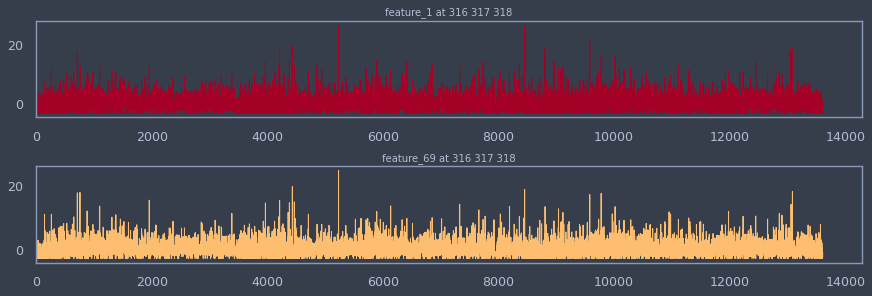

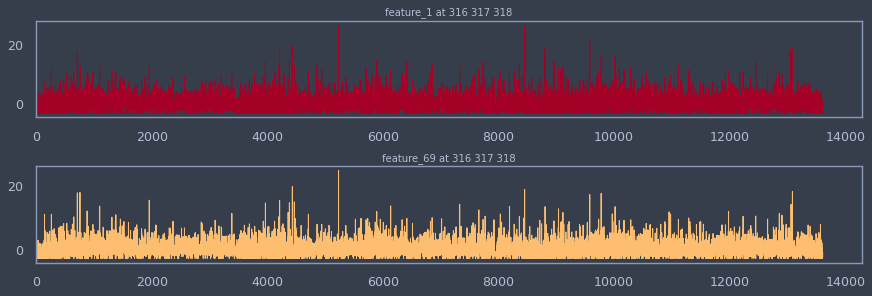

In [14]:
feats = ['feature_1', 'feature_69']
start_day = np.random.randint(0, 500-3, 1)[0]
plot_features(feats, train_final, start_day=start_day)
plot_features(feats, train_data, start_day=start_day)